In [2]:
import os
import pandas as pd
import random
import shutil

# Path to the dataset folder
dataset_path = "/kaggle/input/tamil-fingerprint/TLFS23 - Tamil Language Finger Spelling Image Dataset/Dataset Folders"

# Dictionary to store image counts per label
image_counts = {}

# Iterate through subfolders
for folder in sorted(os.listdir(dataset_path)):
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.isdir(folder_path):  # Ensure it's a directory
        image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        image_counts[folder] = len(image_files)

# Convert to DataFrame for visualization
df = pd.DataFrame(list(image_counts.items()), columns=["Label", "Image Count"])

# Display results in Kaggle Notebook
print(df)

# **Optional: Reduce the dataset by limiting max 500 images per label**
reduced_dataset_path = "/kaggle/working/reduced_TLFS23"
os.makedirs(reduced_dataset_path, exist_ok=True)

for folder, count in image_counts.items():
    folder_path = os.path.join(dataset_path, folder)
    new_folder_path = os.path.join(reduced_dataset_path, folder)
    os.makedirs(new_folder_path, exist_ok=True)
    
    # Select a random subset (max 500 images per label)
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    selected_images = random.sample(image_files, min(500, count))
    
    for img in selected_images:
        shutil.copy(os.path.join(folder_path, img), os.path.join(new_folder_path, img))

print("Dataset reduction complete. Reduced dataset saved at:", reduced_dataset_path)


          Label  Image Count
0             1         1064
1            10         1055
2           100         1014
3           101         1026
4           102         1033
..          ...          ...
243          96         1023
244          97         1009
245          98         1027
246          99         1008
247  Background         1011

[248 rows x 2 columns]
Dataset reduction complete. Reduced dataset saved at: /kaggle/working/reduced_TLFS23


In [1]:
import os
import pandas as pd
import random
import shutil

In [4]:
!pip install mediapipe 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 54.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 1.34.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<4.0.0dev,>=3.19.5, but you have protobuf 4.25.6 which is incompatible.
google-cloud-bigtable 2.27.0 requires google-api-core[grpc]<3.0.0dev,>=2.16.0, but you have google-api-core 1.34.1 which is incompatible.
pandas-gbq 0.25.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible.
tensorflow-decision-forests 1.10.0 requires tens

In [6]:
import os
import numpy as np
import cv2
import mediapipe as mp
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from sklearn.model_selection import train_test_split
import joblib  # For saving keypoints
from tqdm import tqdm
# Set dataset path (CHANGE THIS TO REDUCED DATASET)
DATASET_PATH = "/kaggle/working/reduced_TLFS23"

# Initialize MediaPipe Holistic model
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

# Function to process an image and extract keypoints
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return results

# Function to extract keypoints
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Dictionary to store keypoints
keypoints_data = []
labels = []

# Load dataset and extract keypoints
holistic = mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)

for label in tqdm(sorted(os.listdir(DATASET_PATH))):  # Iterate over class folders
    label_path = os.path.join(DATASET_PATH, label)
    
    if os.path.isdir(label_path):
        for image_name in os.listdir(label_path):
            image_path = os.path.join(label_path, image_name)
            
            # Read image
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip corrupted images

            # Process image
            results = mediapipe_detection(image, holistic)
            
            # Extract keypoints
            keypoints = extract_keypoints(results)
            keypoints_data.append(keypoints)
            labels.append(int(label))  # Convert folder name (e.g., "1", "2") to integer label

# Convert to NumPy arrays
X = np.array(keypoints_data)
y = np.array(labels)

# Save extracted keypoints (for future use)
joblib.dump((X, y), "/kaggle/working/keypoints_data.pkl")
print(f"Keypoints extracted and saved! Shape: {X.shape}")

# Split dataset into train (70%), validation (15%), test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Dataset split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], 1)

100%|█████████▉| 247/248 [1:26:43<00:21, 21.07s/it]


ValueError: invalid literal for int() with base 10: 'Background'

In [12]:
X[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [8]:
import os
import numpy as np
import cv2
import mediapipe as mp
import joblib
from tqdm import tqdm

# Paths
DATASET_PATH = "/kaggle/working/reduced_TLFS23"
BACKGROUND_FOLDER = os.path.join(DATASET_PATH, "Background")
KEYPOINTS_FILE = "/kaggle/working/keypoints_data.pkl"

# Initialize MediaPipe Holistic model
mp_holistic = mp.solutions.holistic

# Function to process an image and extract keypoints
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    return results

# Function to extract keypoints
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Assign a new label for "Background"
background_label = max(labels) + 1 if labels else 0  # If no labels exist yet, assign 0

# Process only the "Background" folder
print(f"Processing Background images... (Label: {background_label})")

background_keypoints = []
background_labels = []

with mp_holistic.Holistic(static_image_mode=True) as holistic:
    for file in tqdm(os.listdir(BACKGROUND_FOLDER)):
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_path = os.path.join(BACKGROUND_FOLDER, file)
            image = cv2.imread(image_path)
            if image is None:
                continue  # Skip corrupted images

            # Process image
            results = mediapipe_detection(image, holistic)

            # Extract keypoints
            keypoints = extract_keypoints(results)
            background_keypoints.append(keypoints)
            background_labels.append(background_label)  # Assign background label

# Append new data to existing dataset
keypoints_data.extend(background_keypoints)
labels.extend(background_labels)

# Convert to NumPy arrays
X = np.array(keypoints_data)
y = np.array(labels)

# Save updated dataset
joblib.dump((X, y), KEYPOINTS_FILE)

print(f"Successfully added 'Background' data. New dataset shape: {X.shape}, {y.shape}")
print(f"Dataset saved to {KEYPOINTS_FILE}")


Processing Background images... (Label: 248)


100%|██████████| 500/500 [00:16<00:00, 29.44it/s]


Successfully added 'Background' data. New dataset shape: (124001, 1662), (124000,)
Dataset saved to /kaggle/working/keypoints_data.pkl


In [10]:
# Check size mismatch
print(f"X shape: {X.shape}, y shape: {y.shape}")

# If X has more samples than y, remove extra entries
if X.shape[0] > y.shape[0]:
    print(f"Trimming X from {X.shape[0]} to {y.shape[0]} samples")
    X = X[:len(y)]  # Trim extra samples

# If y has more labels than X, remove extra labels (rare case)
elif y.shape[0] > X.shape[0]:
    print(f"Trimming y from {y.shape[0]} to {X.shape[0]} labels")
    y = y[:len(X)]

# Confirm both have the same length
print(f"After trimming: X shape = {X.shape}, y shape = {y.shape}")

# Now proceed with splitting
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Dataset split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")


X shape: (124001, 1662), y shape: (124000,)
Trimming X from 124001 to 124000 samples
After trimming: X shape = (124000, 1662), y shape = (124000,)
Dataset split: Train=86800, Val=18600, Test=18600


In [13]:
import joblib
from sklearn.model_selection import train_test_split

# Load saved dataset
KEYPOINTS_FILE = "/kaggle/working/keypoints_data.pkl"
X, y = joblib.load(KEYPOINTS_FILE)

# Check mismatch
print(f"Before trimming: X shape = {X.shape}, y shape = {y.shape}")

# Fix mismatch by trimming the FIRST row of X
if X.shape[0] > y.shape[0]:
    print("Trimming the first row of X...")
    X = X[1:]  # Remove the first row

# Ensure both arrays have the same length
assert X.shape[0] == y.shape[0], "Mismatch still exists!"

print(f"After trimming: X shape = {X.shape}, y shape = {y.shape}")

# Proceed with splitting dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Dataset split: Train={len(X_train)}, Val={len(X_val)}, Test={len(X_test)}")

# Reshape for CNN input
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1, 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1, 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1, 1)

print("Final data shape:", X_train.shape, X_val.shape, X_test.shape)


Before trimming: X shape = (124001, 1662), y shape = (124000,)
Trimming the first row of X...
After trimming: X shape = (124000, 1662), y shape = (124000,)
Dataset split: Train=86800, Val=18600, Test=18600
Final data shape: (86800, 1662, 1, 1) (18600, 1662, 1, 1) (18600, 1662, 1, 1)


In [15]:
num_classes = 248

In [18]:
import os
import cv2
import numpy as np
import mediapipe as mp
import random
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

In [19]:
y_train_cat = to_categorical(y_train - 1, num_classes=num_classes)  # subtract 1 if folder names start at 1
y_val_cat   = to_categorical(y_val - 1, num_classes=num_classes)
y_test_cat  = to_categorical(y_test - 1, num_classes=num_classes)

In [ ]:
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

# Load saved dataset
KEYPOINTS_FILE = "/kaggle/working/keypoints_data.pkl"
X, y = joblib.load(KEYPOINTS_FILE)

# Ensure data consistency (Trim last row if mismatch exists)
if X.shape[0] > y.shape[0]:
    print("Trimming the last row of X to match y...")
    X = X[:-1]  # Drop the last row of X

# Confirm matching shapes
assert X.shape[0] == y.shape[0], "Error: X and y still have mismatched lengths!"

# Split dataset into Train (80%) and Test (20%)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Initialize and Train RandomForest Classifier
print("Training RandomForestClassifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42)  # Adjust hyperparameters if needed
model.fit(x_train, y_train)

# Make Predictions
y_predict = model.predict(x_test)

# Calculate Accuracy
score = accuracy_score(y_test, y_predict)
print(f"{score * 100:.2f}% of samples were classified correctly!")

# Save trained model
with open('/kaggle/working/random_forest_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved as 'random_forest_model.pkl'")


Trimming the last row of X to match y...
Training RandomForestClassifier...
37.01% of samples were classified correctly!


In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tqdm import tqdm

# Initialize Mediapipe Hands (Detect up to 2 hands)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

# Dataset Path (Update as needed)
DATA_DIR = "/kaggle/working/reduced_TLFS23"

# Expected Feature Count: 21 landmarks × 2 hands × 2 (x, y) = 84
EXPECTED_FEATURES = 84

# Lists to store extracted keypoints and labels
data = []
labels = []

# Get all subfolders (class labels)
all_folders = sorted(os.listdir(DATA_DIR))
label_map = {folder: idx for idx, folder in enumerate(all_folders)}
background_label = label_map.get("Background", max(label_map.values()) + 1)  # If not found, assign a new label

print(f"📌 Label Mapping: {label_map}")

# Process each label folder
for dir_ in tqdm(all_folders):
    dir_path = os.path.join(DATA_DIR, dir_)
    if not os.path.isdir(dir_path):
        continue  # Skip if not a directory

    for img_path in os.listdir(dir_path):
        # Read image
        img = cv2.imread(os.path.join(dir_path, img_path))
        if img is None:
            continue  # Skip corrupted images
        img = cv2.resize(img, (256, 256))  # Resize for faster processing
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process image with Mediapipe
        results = hands.process(img_rgb)

        # Initialize placeholders for hand keypoints
        left_hand = np.zeros(21 * 2)  # 42 features (21 landmarks × x, y)
        right_hand = np.zeros(21 * 2)  # 42 features (21 landmarks × x, y)

        # Extract keypoints if hands are detected
        if results.multi_hand_landmarks:
            for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                hand_keypoints = []
                for landmark in hand_landmarks.landmark:
                    hand_keypoints.append(landmark.x)
                    hand_keypoints.append(landmark.y)

                # Assign to left or right hand
                if hand_idx == 0:
                    left_hand = hand_keypoints
                elif hand_idx == 1:
                    right_hand = hand_keypoints

        # Concatenate left & right hand keypoints
        data_aux = np.concatenate([left_hand, right_hand])

        # **Handle Background Images** → No hands detected = All zeros
        if dir_ == "Background":
            data_aux = np.zeros(EXPECTED_FEATURES)  # 84 Zeros

        # Ensure consistency in feature count
        if len(data_aux) == EXPECTED_FEATURES:
            data.append(data_aux)
            labels.append(label_map.get(dir_, background_label))  # Convert folder name to integer label
        else:
            print(f"⚠ Skipped {img_path} in {dir_}: Incorrect features ({len(data_aux)} instead of {EXPECTED_FEATURES})")

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Save dataset as a pickle file
with open("/kaggle/working/hand_keypoints_data.pkl", "wb") as f:
    pickle.dump({"data": data, "labels": labels}, f)

print(f"✅ Dataset saved! Total samples: {len(data)}")


📌 Label Mapping: {'1': 0, '10': 1, '100': 2, '101': 3, '102': 4, '103': 5, '104': 6, '105': 7, '106': 8, '107': 9, '108': 10, '109': 11, '11': 12, '110': 13, '111': 14, '112': 15, '113': 16, '114': 17, '115': 18, '116': 19, '117': 20, '118': 21, '119': 22, '12': 23, '120': 24, '121': 25, '122': 26, '123': 27, '124': 28, '125': 29, '126': 30, '127': 31, '128': 32, '129': 33, '13': 34, '130': 35, '131': 36, '132': 37, '133': 38, '134': 39, '135': 40, '136': 41, '137': 42, '138': 43, '139': 44, '14': 45, '140': 46, '141': 47, '142': 48, '143': 49, '144': 50, '145': 51, '146': 52, '147': 53, '148': 54, '149': 55, '15': 56, '150': 57, '151': 58, '152': 59, '153': 60, '154': 61, '155': 62, '156': 63, '157': 64, '158': 65, '159': 66, '16': 67, '160': 68, '161': 69, '162': 70, '163': 71, '164': 72, '165': 73, '166': 74, '167': 75, '168': 76, '169': 77, '17': 78, '170': 79, '171': 80, '172': 81, '173': 82, '174': 83, '175': 84, '176': 85, '177': 86, '178': 87, '179': 88, '18': 89, '180': 90, '1

 10%|█         | 25/248 [07:26<1:06:18, 17.84s/it]


KeyboardInterrupt: 

In [3]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pickle
from tqdm import tqdm

# Initialize Mediapipe Hands (Detect up to 2 hands)
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.3)

# Dataset Path (Update as needed)
DATA_DIR = "/kaggle/working/reduced_TLFS23"

# Expected Feature Count: 21 landmarks × 2 hands × 2 (x, y) = 84
EXPECTED_FEATURES = 84

# Lists to store extracted keypoints and labels
data = []
labels = []

# Process each folder (each class)
for dir_ in tqdm(sorted(os.listdir(DATA_DIR))):
    dir_path = os.path.join(DATA_DIR, dir_)
    if not os.path.isdir(dir_path):
        continue  # Skip if not a directory

    # Convert folder name to integer (use fixed label for Background)
    if dir_.isdigit():  # Normal class (1 to 247)
        label = int(dir_)
    elif dir_ == "Background":  # Assign fixed label for Background
        label = 247
    else:
        continue  # Ignore unexpected folders

    for img_path in os.listdir(dir_path):
        # Read image
        img = cv2.imread(os.path.join(dir_path, img_path))
        if img is None:
            continue  # Skip corrupted images
        img = cv2.resize(img, (256, 256))  # Resize for faster processing
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Process image with Mediapipe
        results = hands.process(img_rgb)

        # Initialize placeholders for hand keypoints
        left_hand = np.zeros(21 * 2)  # 42 features (21 landmarks × x, y)
        right_hand = np.zeros(21 * 2)  # 42 features (21 landmarks × x, y)

        # Extract keypoints if hands are detected
        if results.multi_hand_landmarks:
            for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
                hand_keypoints = []
                for landmark in hand_landmarks.landmark:
                    hand_keypoints.append(landmark.x)
                    hand_keypoints.append(landmark.y)

                # Assign to left or right hand
                if hand_idx == 0:
                    left_hand = hand_keypoints
                elif hand_idx == 1:
                    right_hand = hand_keypoints

        # Concatenate left & right hand keypoints
        data_aux = np.concatenate([left_hand, right_hand])

        # **Handle Background Images** → No hands detected = All zeros
        if dir_ == "Background":
            data_aux = np.zeros(EXPECTED_FEATURES)  # 84 Zeros

        # Ensure consistency in feature count
        if len(data_aux) == EXPECTED_FEATURES:
            data.append(data_aux)
            labels.append(label)  # Use direct integer labels
        else:
            print(f"⚠ Skipped {img_path} in {dir_}: Incorrect features ({len(data_aux)} instead of {EXPECTED_FEATURES})")

# Convert to NumPy arrays
data = np.array(data)
labels = np.array(labels)

# Save dataset as a pickle file
with open("/kaggle/working/hand_keypoints_data.pkl", "wb") as f:
    pickle.dump({"data": data, "labels": labels}, f)

print(f"✅ Dataset saved! Total samples: {len(data)}")


100%|██████████| 248/248 [1:08:26<00:00, 16.56s/it]


✅ Dataset saved! Total samples: 124000


In [4]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Load the dataset (Ensure this file exists)
dataset_path = "/kaggle/input/hand-keypoints/hand_keypoints_data.pkl"

with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

X = np.array(dataset["data"])
y = np.array(dataset["labels"])

# Split dataset into Train (70%), Validation (15%), Test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Dataset Split: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")

# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_train_pred = rf_model.predict(X_train)
y_val_pred = rf_model.predict(X_val)
y_test_pred = rf_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)
test_acc = accuracy_score(y_test, y_test_pred)

# Save the trained model
model_path = "/kaggle/working/random_forest_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(rf_model, f)

# Display results
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Model saved at: {model_path}")


Dataset Split: Train=86800, Validation=18600, Test=18600
Train Accuracy: 0.8803
Validation Accuracy: 0.8011
Test Accuracy: 0.8036
Model saved at: /kaggle/working/random_forest_model.pkl


In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
print("\n📌 Classification Report:\n")
print(classification_report(y_test, y_test_pred))





📌 Classification Report:

              precision    recall  f1-score   support

           1       0.88      0.68      0.77        75
           2       0.90      0.83      0.86        75
           3       0.89      0.85      0.87        75
           4       0.94      0.83      0.88        75
           5       0.87      0.71      0.78        75
           6       0.90      0.85      0.88        75
           7       0.85      0.77      0.81        75
           8       0.87      0.83      0.85        75
           9       0.93      0.75      0.83        75
          10       0.90      0.72      0.80        75
          11       0.84      0.77      0.81        75
          12       0.86      0.88      0.87        75
          13       0.95      0.84      0.89        75
          14       0.92      0.92      0.92        75
          15       0.89      0.85      0.87        75
          16       0.98      0.79      0.87        75
          17       0.88      0.76      0.81        75


In [ ]:
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# ✅ Enable mixed precision for faster GPU training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# ✅ Load dataset
dataset_path = "/kaggle/input/hand-keypoints/hand_keypoints_data.pkl"
with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

X = np.array(dataset["data"])  # Shape: (samples, 84)
y = np.array(dataset["labels"])  # Already in numerical format

# ✅ Convert labels to one-hot encoding
y_categorical = to_categorical(y)  # Shape: (samples, num_classes)

# ✅ Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, stratify=y_categorical, random_state=42)

# ✅ Reshape input for LSTM: (samples, time steps=1, features=84)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# ✅ Model Checkpoint (Save Best Model)
checkpoint = ModelCheckpoint("/kaggle/working/best_lstm_model.keras", 
                             monitor="val_categorical_accuracy", 
                             save_best_only=True, 
                             mode="max", 
                             verbose=1)

# ✅ Early Stopping (Stops training if no improvement for 10 epochs)
early_stopping = EarlyStopping(monitor="val_categorical_accuracy", 
                               patience=500, 
                               restore_best_weights=True, 
                               verbose=1)

# ✅ Train Model on GPU
with tf.device('/GPU:0'):
    # Define LSTM Model
    model = Sequential([
        LSTM(128, return_sequences=True, activation='relu', input_shape=(1, 84)),
        LSTM(256, return_sequences=True, activation='relu'),
        LSTM(128, return_sequences=False, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(y_categorical.shape[1], activation='softmax')  # Output Layer (num_classes)
    ])

    # Compile Model
    model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    # ✅ Train Model on GPU with Best Model Saving & Early Stopping
    history = model.fit(X_train, y_train, 
                        epochs=1000, 
                        validation_data=(X_test, y_test), 
                        batch_size=64, 
                        callbacks=[checkpoint, early_stopping])

# ✅ Save Final Model (Just in case)
model.save("/kaggle/working/final_lstm_hand_model.keras")
print("✅ Best Model Trained and Saved Successfully on GPU!")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/1000
1526/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.0120 - loss: 5.3064
Epoch 1: val_categorical_accuracy improved from -inf to 0.08625, saving model to /kaggle/working/best_lstm_model.keras
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - categorical_accuracy: 0.0123 - loss: 5.2992 - val_categorical_accuracy: 0.0862 - val_loss: 3.8334
Epoch 2/1000
1541/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1031 - loss: 3.6939
Epoch 2: val_categorical_accuracy improved from 0.08625 to 0.13597, saving model to /kaggle/working/best_lstm_model.keras
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - categorical_accuracy: 0.1032 - loss: 3.6930 - val_categorical_accuracy: 0.1360 - val_loss: 3.3771
Epoch 3/1000
1537/1550 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - categorical_accuracy: 0.1980 - loss: 3.1135
Epoch 3: val_categorical_accuracy improved from 0.13597 to 0.32190, saving model to /kaggle/working/best_lstm_model.keras
1550/1550 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step -

✅ Model Loaded Successfully!
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

📊 Classification Report:
              precision    recall  f1-score   support

           1     0.8750    0.8400    0.8571       100
           2     0.9121    0.8300    0.8691       100
           3     0.8519    0.6900    0.7624       100
           4     0.9000    0.8100    0.8526       100
           5     0.8434    0.7000    0.7650       100
           6     0.9655    0.8400    0.8984       100
           7     0.9398    0.7800    0.8525       100
           8     0.9667    0.8700    0.9158       100
           9     0.9368    0.8900    0.9128       100
          10     0.9529    0.8100    0.8757       100
          11     0.8830    0.8300    0.8557       100
          12     0.8737    0.8300    0.8513       100
          13     0.9884    0.8500    0.9140       100
          14     0.9348    0.8600    0.8958       100
          15     0.8602    0.8000    0.8290       100
          16     1.0000    0.8500    0.

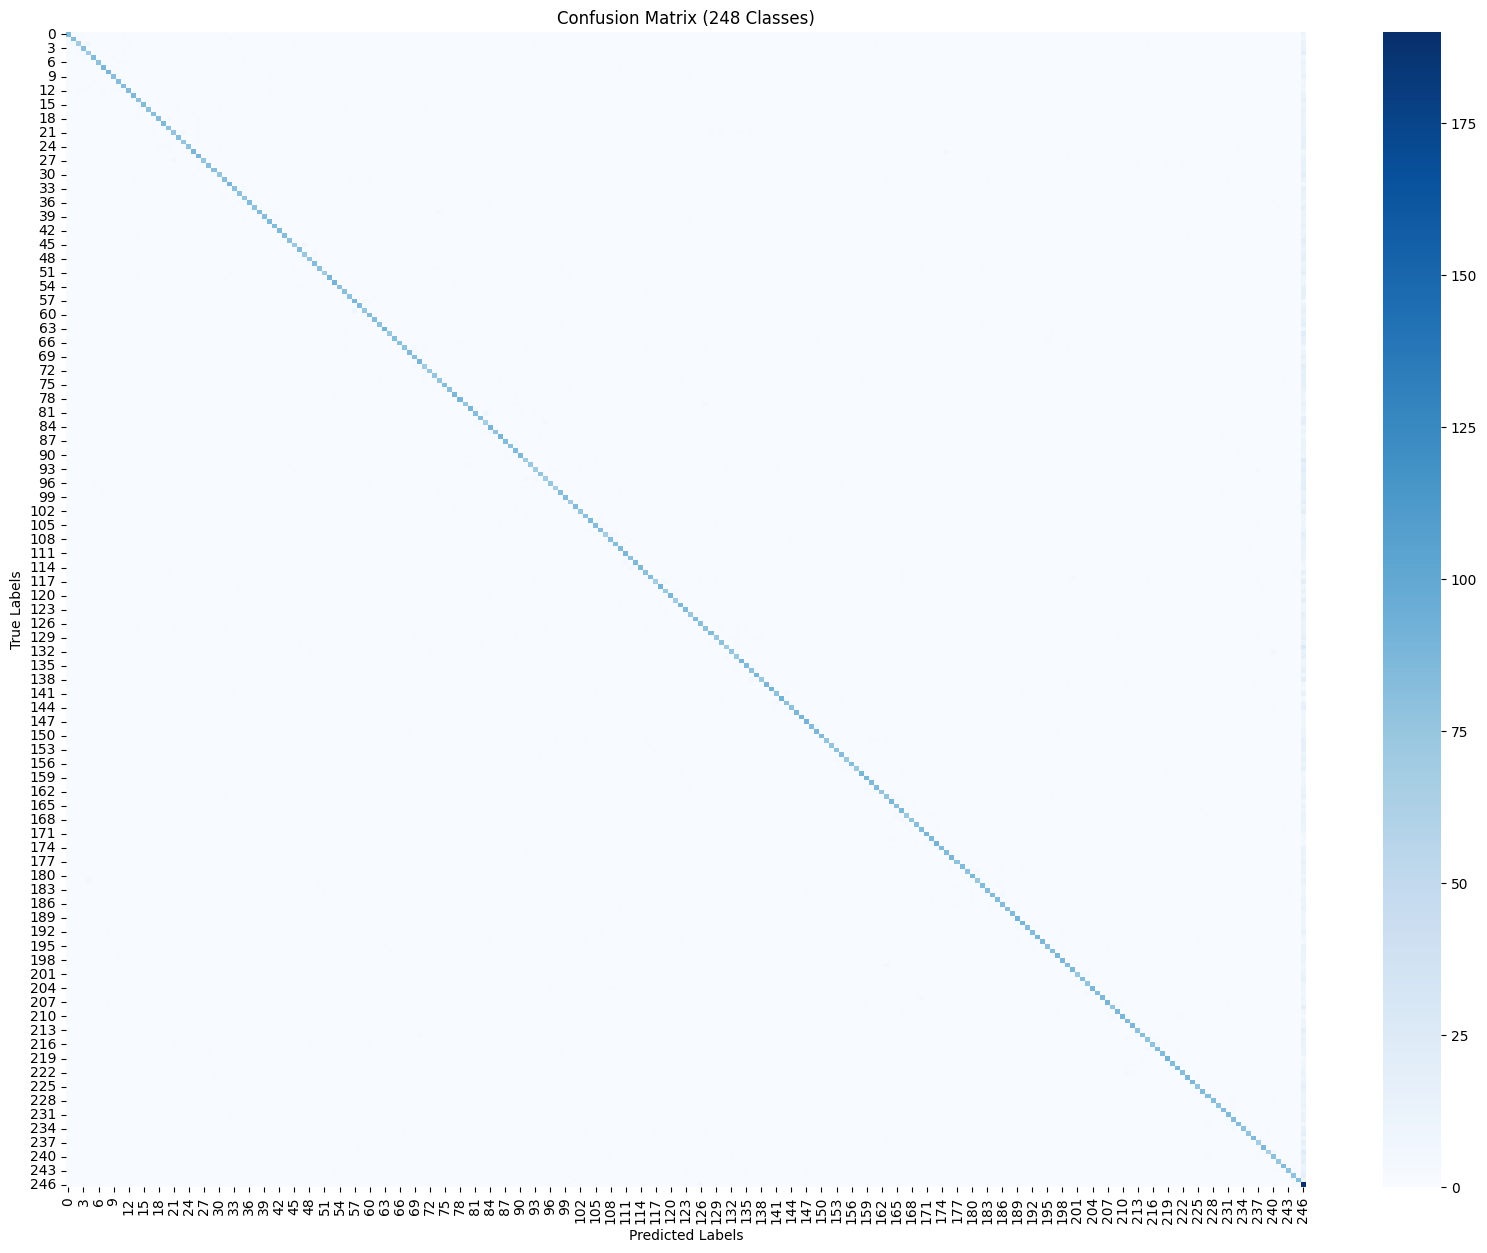

In [9]:


# ✅ Load the trained Transformer model
model_path = "/kaggle/working/best_lstm_model.keras"  # Update this path if needed
model = tf.keras.models.load_model(model_path)
print("✅ Model Loaded Successfully!")



# ✅ Reshape input for Transformer: (samples, time steps=1, features=84)
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# ✅ Make Predictions
y_pred_probs = model.predict(X_test)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot labels to class indices

# ✅ Print Classification Report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, digits=4))

# ✅ Compute Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# ✅ Plot Confusion Matrix (Handling 248 classes effectively)
plt.figure(figsize=(20, 15))  # Increase figure size for better visualization
sns.heatmap(conf_matrix, annot=False, cmap="Blues")  # Avoiding too much clutter
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (248 Classes)")
plt.show()


In [ ]:
import json
import os

# Create the Tamil character label mapping
def create_tamil_label_mapping(output_file="tamil_labels.json"):
    """
    Create a mapping of label IDs to Tamil characters with their pronunciation.
    
    Args:
        output_file: Path to save the label mapping JSON file
    """
    # Dictionary to store label mapping
    label_map = {}
    
    # Add all Tamil characters from the provided list
    label_map[1] = {"tamil": "அ", "pronunciation": "a"}
    label_map[2] = {"tamil": "ஆ", "pronunciation": "ā"}
    label_map[3] = {"tamil": "இ", "pronunciation": "i"}
    label_map[4] = {"tamil": "ஈ", "pronunciation": "ī"}
    label_map[5] = {"tamil": "உ", "pronunciation": "u"}
    label_map[6] = {"tamil": "ஊ", "pronunciation": "ū"}
    label_map[7] = {"tamil": "எ", "pronunciation": "e"}
    label_map[8] = {"tamil": "ஏ", "pronunciation": "ē"}
    label_map[9] = {"tamil": "ஐ", "pronunciation": "ai"}
    label_map[10] = {"tamil": "ஒ", "pronunciation": "o"}
    label_map[11] = {"tamil": "ஓ", "pronunciation": "ō"}
    label_map[12] = {"tamil": "ஔ", "pronunciation": "au"}
    label_map[13] = {"tamil": "ஃ", "pronunciation": "ak"}
    label_map[14] = {"tamil": "க்", "pronunciation": "k"}
    label_map[15] = {"tamil": "ங்", "pronunciation": "ṅ"}
    label_map[16] = {"tamil": "ச்", "pronunciation": "c"}
    label_map[17] = {"tamil": "ஞ்", "pronunciation": "ñ"}
    label_map[18] = {"tamil": "ட்", "pronunciation": "ṭ"}
    label_map[19] = {"tamil": "ண்", "pronunciation": "ṇ"}
    label_map[20] = {"tamil": "த்", "pronunciation": "t"}
    label_map[21] = {"tamil": "ந்", "pronunciation": "n"}
    label_map[22] = {"tamil": "ப்", "pronunciation": "p"}
    label_map[23] = {"tamil": "ம்", "pronunciation": "m"}
    label_map[24] = {"tamil": "ய்", "pronunciation": "y"}
    label_map[25] = {"tamil": "ர்", "pronunciation": "r"}
    label_map[26] = {"tamil": "ல்", "pronunciation": "l"}
    label_map[27] = {"tamil": "வ்", "pronunciation": "v"}
    label_map[28] = {"tamil": "ழ்", "pronunciation": "lzh"}
    label_map[29] = {"tamil": "ள்", "pronunciation": "ll"}
    label_map[30] = {"tamil": "ற்", "pronunciation": "ṟ"}
    label_map[31] = {"tamil": "ன்", "pronunciation": "ṉ"}
    label_map[32] = {"tamil": "க", "pronunciation": "Ka"}
    label_map[33] = {"tamil": "கா", "pronunciation": "Kā"}
    label_map[34] = {"tamil": "கி", "pronunciation": "Ki"}
    label_map[35] = {"tamil": "கீ", "pronunciation": "Kī"}
    label_map[36] = {"tamil": "கு", "pronunciation": "Ku"}
    label_map[37] = {"tamil": "கூ", "pronunciation": "Kū"}
    label_map[38] = {"tamil": "கெ", "pronunciation": "Ke"}
    label_map[39] = {"tamil": "கே", "pronunciation": "Kē"}
    label_map[40] = {"tamil": "கை", "pronunciation": "Kai"}
    label_map[41] = {"tamil": "கொ", "pronunciation": "Ko"}
    label_map[42] = {"tamil": "கோ", "pronunciation": "Kō"}
    label_map[43] = {"tamil": "கௌ", "pronunciation": "Kau"}
    label_map[44] = {"tamil": "ங", "pronunciation": "Nga"}
    label_map[45] = {"tamil": "ஙா", "pronunciation": "Ngā"}
    label_map[46] = {"tamil": "ஙி", "pronunciation": "Ngi"}
    label_map[47] = {"tamil": "ஙீ", "pronunciation": "Ngī"}
    label_map[48] = {"tamil": "ஙு", "pronunciation": "Ngu"}
    label_map[49] = {"tamil": "ஙூ", "pronunciation": "Ngū"}
    label_map[50] = {"tamil": "ஙெ", "pronunciation": "Nge"}
    label_map[51] = {"tamil": "ஙே", "pronunciation": "Ngē"}
    label_map[52] = {"tamil": "ஙை", "pronunciation": "Ngai"}
    label_map[53] = {"tamil": "ஙொ", "pronunciation": "Ngo"}
    label_map[54] = {"tamil": "ஙோ", "pronunciation": "Ngō"}
    label_map[55] = {"tamil": "ஙௌ", "pronunciation": "Ngau"}
    label_map[56] = {"tamil": "ச", "pronunciation": "Sa"}
    label_map[57] = {"tamil": "சா", "pronunciation": "Sā"}
    label_map[58] = {"tamil": "சி", "pronunciation": "Si"}
    label_map[59] = {"tamil": "சீ", "pronunciation": "Sī"}
    label_map[60] = {"tamil": "சு", "pronunciation": "Su"}
    label_map[61] = {"tamil": "சூ", "pronunciation": "Sū"}
    label_map[62] = {"tamil": "செ", "pronunciation": "Se"}
    label_map[63] = {"tamil": "சே", "pronunciation": "Sē"}
    label_map[64] = {"tamil": "சை", "pronunciation": "Sai"}
    label_map[65] = {"tamil": "சொ", "pronunciation": "So"}
    label_map[66] = {"tamil": "சோ", "pronunciation": "Sō"}
    label_map[67] = {"tamil": "சௌ", "pronunciation": "Sau"}
    label_map[68] = {"tamil": "ஞ", "pronunciation": "Ña"}
    label_map[69] = {"tamil": "ஞா", "pronunciation": "Ñā"}
    label_map[70] = {"tamil": "ஞி", "pronunciation": "Ñi"}
    label_map[71] = {"tamil": "ஞீ", "pronunciation": "Ñī"}
    label_map[72] = {"tamil": "ஞு", "pronunciation": "Ñu"}
    label_map[73] = {"tamil": "ஞூ", "pronunciation": "Ñū"}
    label_map[74] = {"tamil": "ஞெ", "pronunciation": "Ñe"}
    label_map[75] = {"tamil": "ஞே", "pronunciation": "Ñē"}
    label_map[76] = {"tamil": "ஞை", "pronunciation": "Ñai"}
    label_map[77] = {"tamil": "ஞொ", "pronunciation": "Ño"}
    label_map[78] = {"tamil": "ஞோ", "pronunciation": "Ñō"}
    label_map[79] = {"tamil": "ஞௌ", "pronunciation": "Ñau"}
    label_map[80] = {"tamil": "ட", "pronunciation": "Ṭa"}
    label_map[81] = {"tamil": "டா", "pronunciation": "Ṭā"}
    label_map[82] = {"tamil": "டி", "pronunciation": "Ṭi"}
    label_map[83] = {"tamil": "டீ", "pronunciation": "Ṭī"}
    label_map[84] = {"tamil": "டு", "pronunciation": "Ṭu"}
    label_map[85] = {"tamil": "டூ", "pronunciation": "Ṭū"}
    label_map[86] = {"tamil": "டெ", "pronunciation": "Ṭe"}
    label_map[87] = {"tamil": "டே", "pronunciation": "Ṭē"}
    label_map[88] = {"tamil": "டை", "pronunciation": "Ṭai"}
    label_map[89] = {"tamil": "டொ", "pronunciation": "Ṭo"}
    label_map[90] = {"tamil": "டோ", "pronunciation": "Ṭō"}
    label_map[91] = {"tamil": "டௌ", "pronunciation": "Ṭau"}
    label_map[92] = {"tamil": "ண", "pronunciation": "Ṇa"}
    label_map[93] = {"tamil": "ணா", "pronunciation": "Ṇā"}
    label_map[94] = {"tamil": "ணி", "pronunciation": "Ṇi"}
    label_map[95] = {"tamil": "ணீ", "pronunciation": "Ṇī"}
    label_map[96] = {"tamil": "ணு", "pronunciation": "Ṇu"}
    label_map[97] = {"tamil": "ணூ", "pronunciation": "Ṇū"}
    label_map[98] = {"tamil": "ணெ", "pronunciation": "Ṇe"}
    label_map[99] = {"tamil": "ணே", "pronunciation": "Ṇē"}
    label_map[100] = {"tamil": "ணை", "pronunciation": "Ṇai"}
    label_map[101] = {"tamil": "ணொ", "pronunciation": "Ṇo"}
    label_map[102] = {"tamil": "ணோ", "pronunciation": "Ṇō"}
    label_map[103] = {"tamil": "ணௌ", "pronunciation": "Ṇau"}
    label_map[104] = {"tamil": "த", "pronunciation": "Ta"}
    label_map[105] = {"tamil": "தா", "pronunciation": "Tā"}
    label_map[106] = {"tamil": "தி", "pronunciation": "Ti"}
    label_map[107] = {"tamil": "தீ", "pronunciation": "Tī"}
    label_map[108] = {"tamil": "து", "pronunciation": "Tu"}
    label_map[109] = {"tamil": "தூ", "pronunciation": "Tū"}
    label_map[110] = {"tamil": "தெ", "pronunciation": "Te"}
    label_map[111] = {"tamil": "தே", "pronunciation": "Tē"}
    label_map[112] = {"tamil": "தை", "pronunciation": "Tai"}
    label_map[113] = {"tamil": "தொ", "pronunciation": "To"}
    label_map[114] = {"tamil": "தோ", "pronunciation": "Tō"}
    label_map[115] = {"tamil": "தௌ", "pronunciation": "Tau"}
    label_map[116] = {"tamil": "ந", "pronunciation": "Na"}
    label_map[117] = {"tamil": "நா", "pronunciation": "Nā"}
    label_map[118] = {"tamil": "நி", "pronunciation": "Ni"}
    label_map[119] = {"tamil": "நீ", "pronunciation": "Nī"}
    label_map[120] = {"tamil": "நு", "pronunciation": "Nu"}
    label_map[121] = {"tamil": "நூ", "pronunciation": "Nū"}
    label_map[122] = {"tamil": "நெ", "pronunciation": "Ne"}
    label_map[123] = {"tamil": "நே", "pronunciation": "Nē"}
    label_map[124] = {"tamil": "நை", "pronunciation": "Nai"}
    label_map[125] = {"tamil": "நொ", "pronunciation": "No"}
    label_map[126] = {"tamil": "நோ", "pronunciation": "Nō"}
    label_map[127] = {"tamil": "நௌ", "pronunciation": "Nau"}
    label_map[128] = {"tamil": "ப", "pronunciation": "Pa"}
    label_map[129] = {"tamil": "பா", "pronunciation": "Pā"}
    label_map[130] = {"tamil": "பி", "pronunciation": "Pi"}
    label_map[131] = {"tamil": "பீ", "pronunciation": "Pī"}
    label_map[132] = {"tamil": "பு", "pronunciation": "Pu"}
    label_map[133] = {"tamil": "பூ", "pronunciation": "Pū"}
    label_map[134] = {"tamil": "பெ", "pronunciation": "Pe"}
    label_map[135] = {"tamil": "பே", "pronunciation": "Pē"}
    label_map[136] = {"tamil": "பை", "pronunciation": "Pai"}
    label_map[137] = {"tamil": "பொ", "pronunciation": "Po"}
    label_map[138] = {"tamil": "போ", "pronunciation": "Pō"}
    label_map[139] = {"tamil": "பௌ", "pronunciation": "Pau"}
    label_map[140] = {"tamil": "ம", "pronunciation": "Ma"}
    label_map[141] = {"tamil": "மா", "pronunciation": "Mā"}
    label_map[142] = {"tamil": "மி", "pronunciation": "Mi"}
    label_map[143] = {"tamil": "மீ", "pronunciation": "Mī"}
    label_map[144] = {"tamil": "மு", "pronunciation": "Mu"}
    label_map[145] = {"tamil": "மூ", "pronunciation": "Mū"}
    label_map[146] = {"tamil": "மெ", "pronunciation": "Me"}
    label_map[147] = {"tamil": "மே", "pronunciation": "Mē"}
    label_map[148] = {"tamil": "மை", "pronunciation": "Mai"}
    label_map[149] = {"tamil": "மொ", "pronunciation": "Mo"}
    label_map[150] = {"tamil": "மோ", "pronunciation": "Mō"}
    label_map[151] = {"tamil": "மௌ", "pronunciation": "Mau"}
    label_map[152] = {"tamil": "ய", "pronunciation": "Ya"}
    label_map[153] = {"tamil": "யா", "pronunciation": "Yā"}
    label_map[154] = {"tamil": "யி", "pronunciation": "Yi"}
    label_map[155] = {"tamil": "யீ", "pronunciation": "Yī"}
    label_map[156] = {"tamil": "யு", "pronunciation": "Yu"}
    label_map[157] = {"tamil": "யூ", "pronunciation": "Yū"}
    label_map[158] = {"tamil": "யெ", "pronunciation": "Ye"}
    label_map[159] = {"tamil": "யே", "pronunciation": "Yē"}
    label_map[160] = {"tamil": "யை", "pronunciation": "Yai"}
    label_map[161] = {"tamil": "யொ", "pronunciation": "Yo"}
    label_map[162] = {"tamil": "யோ", "pronunciation": "Yō"}
    label_map[163] = {"tamil": "யௌ", "pronunciation": "Yau"}
    label_map[164] = {"tamil": "ர", "pronunciation": "Ra"}
    label_map[165] = {"tamil": "ரா", "pronunciation": "Rā"}
    label_map[166] = {"tamil": "ரி", "pronunciation": "Ri"}
    label_map[167] = {"tamil": "ரீ", "pronunciation": "Rī"}
    label_map[168] = {"tamil": "ரு", "pronunciation": "Ru"}
    label_map[169] = {"tamil": "ரூ", "pronunciation": "Rū"}
    label_map[170] = {"tamil": "ரெ", "pronunciation": "Re"}
    label_map[171] = {"tamil": "ரே", "pronunciation": "Rē"}
    label_map[172] = {"tamil": "ரை", "pronunciation": "Rai"}
    label_map[173] = {"tamil": "ரொ", "pronunciation": "Ro"}
    label_map[174] = {"tamil": "ரோ", "pronunciation": "Rō"}
    label_map[175] = {"tamil": "ரௌ", "pronunciation": "Rau"}
    label_map[176] = {"tamil": "ல", "pronunciation": "La"}
    label_map[177] = {"tamil": "லா", "pronunciation": "Lā"}
    label_map[178] = {"tamil": "லி", "pronunciation": "Li"}
    label_map[179] = {"tamil": "லீ", "pronunciation": "Lī"}
    label_map[180] = {"tamil": "லு", "pronunciation": "Lu"}
    label_map[181] = {"tamil": "லூ", "pronunciation": "Lū"}
    label_map[182] = {"tamil": "லெ", "pronunciation": "Le"}
    label_map[183] = {"tamil": "லே", "pronunciation": "Lē"}
    label_map[184] = {"tamil": "லை", "pronunciation": "Lai"}
    label_map[185] = {"tamil": "லொ", "pronunciation": "Lo"}
    label_map[186] = {"tamil": "லோ", "pronunciation": "Lō"}
    label_map[187] = {"tamil": "லௌ", "pronunciation": "Lau"}
    label_map[188] = {"tamil": "வ", "pronunciation": "Va"}
    label_map[189] = {"tamil": "வா", "pronunciation": "Vā"}
    label_map[190] = {"tamil": "வி", "pronunciation": "Vi"}
    label_map[191] = {"tamil": "வீ", "pronunciation": "Vī"}
    label_map[192] = {"tamil": "வு", "pronunciation": "Vu"}
    label_map[193] = {"tamil": "வூ", "pronunciation": "Vū"}
    label_map[194] = {"tamil": "வெ", "pronunciation": "Ve"}
    label_map[195] = {"tamil": "வே", "pronunciation": "Vē"}
    label_map[196] = {"tamil": "வை", "pronunciation": "Vai"}
    label_map[197] = {"tamil": "வொ", "pronunciation": "Vo"}
    label_map[198] = {"tamil": "வோ", "pronunciation": "Vō"}
    label_map[199] = {"tamil": "வௌ", "pronunciation": "Vau"}
    label_map[200] = {"tamil": "ழ", "pronunciation": "Lzha"}
    label_map[201] = {"tamil": "ழா", "pronunciation": "Lzhā"}
    label_map[202] = {"tamil": "ழி", "pronunciation": "Lzhi"}
    label_map[203] = {"tamil": "ழீ", "pronunciation": "Lzhī"}
    label_map[204] = {"tamil": "ழு", "pronunciation": "Lzhu"}
    label_map[205] = {"tamil": "ழூ", "pronunciation": "Lzhū"}
    label_map[206] = {"tamil": "ழெ", "pronunciation": "Lzhe"}
    label_map[207] = {"tamil": "ழே", "pronunciation": "Lzhē"}
    label_map[208] = {"tamil": "ழை", "pronunciation": "Lzhai"}
    label_map[209] = {"tamil": "ழொ", "pronunciation": "Lzho"}
    label_map[210] = {"tamil": "ழோ", "pronunciation": "Lzhō"}
    label_map[211] = {"tamil": "ழௌ", "pronunciation": "Lzhau"}
    label_map[212] = {"tamil": "ள", "pronunciation": "Lla"}
    label_map[213] = {"tamil": "ளா", "pronunciation": "Llā"}
    label_map[214] = {"tamil": "ளி", "pronunciation": "Lli"}
    label_map[215] = {"tamil": "ளீ", "pronunciation": "Llī"}
    label_map[216] = {"tamil": "ளு", "pronunciation": "Llu"}
    label_map[217] = {"tamil": "ளூ", "pronunciation": "Llū"}
    label_map[218] = {"tamil": "ளெ", "pronunciation": "Lle"}
    label_map[219] = {"tamil": "ளே", "pronunciation": "Llē"}
    label_map[220] = {"tamil": "ளை", "pronunciation": "Llai"}
    label_map[221] = {"tamil": "ளொ", "pronunciation": "Llo"}
    label_map[222] = {"tamil": "ளோ", "pronunciation": "Llō"}
    label_map[223] = {"tamil": "ளௌ", "pronunciation": "Llau"}
    label_map[224] = {"tamil": "ற", "pronunciation": "Ṟa"}
    label_map[225] = {"tamil": "றா", "pronunciation": "Ṟā"}
    label_map[226] = {"tamil": "றி", "pronunciation": "Ṟi"}
    label_map[227] = {"tamil": "றீ", "pronunciation": "Ṟī"}
    label_map[228] = {"tamil": "று", "pronunciation": "Ṟu"}
    label_map[229] = {"tamil": "றூ", "pronunciation": "Ṟū"}
    label_map[230] = {"tamil": "றெ", "pronunciation": "Ṟe"}
    label_map[231] = {"tamil": "றே", "pronunciation": "Ṟē"}
    label_map[232] = {"tamil": "றை", "pronunciation": "Ṟai"}
    label_map[233] = {"tamil": "றொ", "pronunciation": "Ṟo"}
    label_map[234] = {"tamil": "றோ", "pronunciation": "Ṟō"}
    label_map[235] = {"tamil": "றௌ", "pronunciation": "Ṟau"}
    label_map[236] = {"tamil": "ன", "pronunciation": "Ṉa"}
    label_map[237] = {"tamil": "னா", "pronunciation": "Ṉā"}
    label_map[238] = {"tamil": "னி", "pronunciation": "Ṉi"}
    label_map[239] = {"tamil": "னீ", "pronunciation": "Ṉī"}
    label_map[240] = {"tamil": "னு", "pronunciation": "Ṉu"}
    label_map[241] = {"tamil": "னூ", "pronunciation": "Ṉū"}
    label_map[242] = {"tamil": "னெ", "pronunciation": "Ṉe"}
    label_map[243] = {"tamil": "னே", "pronunciation": "Ṉē"}
    label_map[244] = {"tamil": "னை", "pronunciation": "Ṉai"}
    label_map[245] = {"tamil": "னொ", "pronunciation": "Ṉo"}
    label_map[246] = {"tamil": "னோ", "pronunciation": "Ṉō"}
    label_map[247] = {"tamil": "னௌ", "pronunciation": "Ṉau"}
    
    # Background class (using index 247 as mentioned in your model's code)
    label_map[248] = {"tamil": "Background", "pronunciation": "Background"}
    
    # Save the mapping to a JSON file
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(label_map, f, indent=4, ensure_ascii=False)
    
    print(f"Tamil label mapping saved to {output_file}")
    print(f"Total classes: {len(label_map)}")
    
    return label_map

if __name__ == "__main__":
    create_tamil_label_mapping("tamil_labels.json")
    print("✅ Tamil character label mapping created successfully!")

Tamil label mapping saved to tamil_labels.json
Total classes: 247
✅ Tamil character label mapping created successfully!
